# <center><h1 style = "color:navy;">Association rules mining</h1></center>

In [178]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from collections import Counter
from scipy.stats import iqr
from sklearn.metrics import jaccard_score
from itertools import combinations

import networkx as nx

import warnings
warnings.filterwarnings("ignore")


#### <h3 style="color:midnightblue"> Load data</h3>

In [179]:
excelf = pd.ExcelFile("Online retail.xlsx")

In [180]:
excelf.sheet_names

['Sheet1']

In [181]:
retail_transaction = pd.read_excel("Online retail.xlsx", header=None)

In [182]:
retail_transaction.rename(columns={0:"Transaction"}, inplace=True)
retail_transaction

,Transaction
0,"shrimp,almonds,avocado,vegetables mix,green gr..."
1,"burgers,meatballs,eggs"
2,chutney
3,"turkey,avocado"
4,"mineral water,milk,energy bar,whole wheat rice..."
...,...
7496,"butter,light mayo,fresh bread"
7497,"burgers,frozen vegetables,eggs,french fries,ma..."
7498,chicken
7499,"escalope,green tea"


We have 7501 rows of transaction data.

## <h2 style="color:purple">1. Data Preprocessing</h2>

#### <h3 style="color:midnightblue"> Detect missing values</h3>

In [183]:
#missing values indicators

missing_values =["","NaN","null","Null","NULL","-"]

In [184]:
retail_transaction["Has Missing"] = retail_transaction["Transaction"].apply(lambda x: any(val in x.split(",")for val in missing_values))

In [185]:
retail_transaction[retail_transaction["Has Missing"] == True]

,Transaction,Has Missing


In [186]:
missing_count = retail_transaction["Has Missing"].sum()
print("Transactions with missing values:\n", retail_transaction[retail_transaction["Has Missing"]])
print(f"\nTotal missing transactions: {missing_count}")

Transactions with missing values:
 Empty DataFrame
Columns: [Transaction, Has Missing]
Index: []

Total missing transactions: 0


#### Our dataset doesn't have any missing values

#### <h3 style="color:midnightblue"> Detect duplicates and remove them</h3>

In [187]:
retail_transaction[retail_transaction.duplicated()]

,Transaction,Has Missing
34,cookies,False
42,spaghetti,False
60,spaghetti,False
64,"turkey,eggs",False
65,french fries,False
...,...,...
7491,herb & pepper,False
7492,"chocolate,escalope",False
7495,"pancakes,light mayo",False
7498,chicken,False


In [188]:
retail_transaction.drop_duplicates(inplace=True)

In [189]:
retail_transaction.shape

(5176, 2)

#### <h3 style="color:midnightblue"> Detect and remove outliers</h3>

#### 1. Check for rare items

In [190]:
# Convert transactions into a list of sets
transaction_sets = [set(t.split(',')) for t in retail_transaction["Transaction"]]
len(transaction_sets)

5176

In [191]:
# Flatten item list and count frequency of each item
# This will give a list of one item item-set
item_counts = Counter(item for t in transaction_sets for item in t)
#item_counts

In [192]:
# Find rare items (appearing in ≤ 10 transactions)
min_support_threshold = 10  # Change as needed
rare_items = {item for item, count in item_counts.items() if count <= min_support_threshold}
print("Rare items (potential outliers):", rare_items)

Rare items (potential outliers): {'napkins', ' asparagus', 'water spray', 'cream'}


If an item appears in very few transactions, it may not contribute to strong association rules. We can remove them.

In [193]:
filtered_transactions = [{item for item in t if item not in rare_items} for t in transaction_sets]
len(filtered_transactions)

5176

This didn't change the number of transactions, that means it wasn't something that was bought standalone.

#### 2. Check transactions for extreme lengths

In [194]:
# Calculate transaction lengths
transaction_lengths = np.array([len(t) for t in transaction_sets])

In [195]:
# Identify outliers in transaction length using IQR
q1, q3 = np.percentile(transaction_lengths, [25, 75])
iqr_value = iqr(transaction_lengths)
lower_bound = q1 - 1.5 * iqr_value
upper_bound = q3 + 1.5 * iqr_value
length_outliers = [i for i, length in enumerate(transaction_lengths) if length < lower_bound or length > upper_bound]
print("Transactions with unusual length:", length_outliers)

Transactions with unusual length: [0, 555, 779, 886, 892, 903, 910, 955, 1105, 1247, 1250, 1256, 1263, 1325, 1330, 1353, 1461, 1624, 1690, 1800, 1882, 2006, 2012, 2041, 2086, 2271, 2277, 2507, 2533, 2551, 2575, 2583, 2586, 2692, 2798, 3318, 3368, 3487, 3569, 3584, 3635, 3742, 3843, 4205, 4516, 4547, 4600]


These transactions length either means it was some error in data entry or the customers bought in bulk which doesn't represent the population we are curious about. Hence, we will delete them.

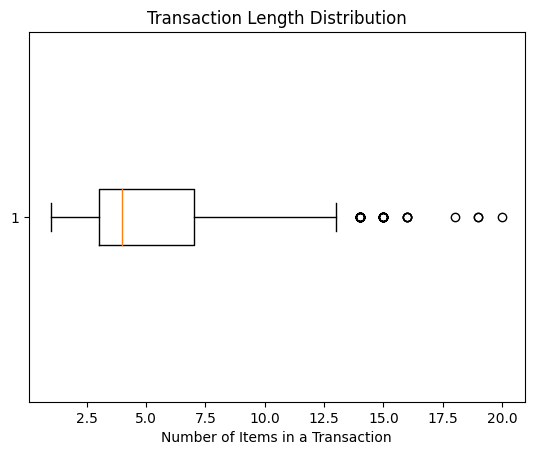

In [196]:
# Visualize transaction length distribution
plt.boxplot(transaction_lengths, vert=False)
plt.title("Transaction Length Distribution")
plt.xlabel("Number of Items in a Transaction")
plt.show()

In [197]:
len(length_outliers)

47

#### Remove Transactions with Extreme Lengths

In [198]:
filtered_transactions = [t for i, t in enumerate(filtered_transactions) if i not in length_outliers]


In [199]:
len(filtered_transactions)

5129

## <h2 style="color:purple">2. Association Rule mining </h2>

We will use transacton encoder to change the dataset into appropriate format for implementing Apriori algorithm

In [200]:
te = TransactionEncoder()
te_ary = te.fit_transform(filtered_transactions)
te_ary

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False]])

In [201]:
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

In [202]:
df_encoded.head(5)

,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,...,toothpaste,turkey,vegetables mix,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


We will create a function that sets support and confidence according to the parameters passed and return the rules. We will use the same function to test various combination of support and confidence to get the support and confidence values.

In [203]:
def optimize_thresholds(min_support=0.01, min_confidence=0.4):
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    return rules

We will first find out the optimal support and confidence and then narrow down the rules later

**1. When support = 0.01 and confidence = 0.4**

In [204]:
rules = optimize_thresholds()
# Reducing Redundant Rules (Leverage & Jaccard Filter)
rules = rules[(rules['leverage'] > 0) & (rules['lift'] > 1)]
rules.sort_values(by='leverage', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2,(ground beef),(spaghetti),0.133554,0.225385,0.054007,0.404380,1.794172,1.0,0.023905,1.300518,0.510869,0.177110,0.231075,0.321999
1,(ground beef),(mineral water),0.133554,0.296939,0.056931,0.426277,1.435572,1.0,0.017274,1.225437,0.350182,0.152401,0.183965,0.309002
7,(soup),(mineral water),0.069799,0.296939,0.032560,0.466480,1.570964,1.0,0.011834,1.317779,0.390720,0.097433,0.241148,0.288066
4,(olive oil),(mineral water),0.085007,0.296939,0.036654,0.431193,1.452126,1.0,0.011412,1.236027,0.340280,0.106155,0.190956,0.277317
29,"(ground beef, mineral water)",(spaghetti),0.056931,0.225385,0.023396,0.410959,1.823364,1.0,0.010565,1.315044,0.478823,0.090361,0.239569,0.257383
0,(cooking oil),(mineral water),0.070384,0.296939,0.028271,0.401662,1.352675,1.0,0.007371,1.175023,0.280465,0.083381,0.148953,0.248434
28,"(ground beef, spaghetti)",(mineral water),0.054007,0.296939,0.023396,0.433213,1.458929,1.0,0.007360,1.240433,0.332524,0.071429,0.193830,0.256002
34,"(spaghetti, milk)",(mineral water),0.046988,0.296939,0.020667,0.439834,1.481227,1.0,0.006714,1.255094,0.340902,0.063932,0.203247,0.254717
12,"(chocolate, milk)",(mineral water),0.043673,0.296939,0.019497,0.446429,1.503435,1.0,0.006529,1.270046,0.350149,0.060716,0.212627,0.256044
23,"(ground beef, frozen vegetables)",(spaghetti),0.023591,0.225385,0.011698,0.495868,2.200092,1.0,0.006381,1.536531,0.558653,0.049302,0.349183,0.273885


**2. When support = 0.02 and confidence = 0.4**

In [205]:
rules = optimize_thresholds(0.02,0.4)
# Reducing Redundant Rules (Leverage & Jaccard Filter)
rules = rules[(rules['leverage'] > 0) & (rules['lift'] > 1)]
rules.sort_values(by='leverage', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2,(ground beef),(spaghetti),0.133554,0.225385,0.054007,0.404380,1.794172,1.0,0.023905,1.300518,0.510869,0.177110,0.231075,0.321999
1,(ground beef),(mineral water),0.133554,0.296939,0.056931,0.426277,1.435572,1.0,0.017274,1.225437,0.350182,0.152401,0.183965,0.309002
4,(soup),(mineral water),0.069799,0.296939,0.032560,0.466480,1.570964,1.0,0.011834,1.317779,0.390720,0.097433,0.241148,0.288066
3,(olive oil),(mineral water),0.085007,0.296939,0.036654,0.431193,1.452126,1.0,0.011412,1.236027,0.340280,0.106155,0.190956,0.277317
7,"(ground beef, mineral water)",(spaghetti),0.056931,0.225385,0.023396,0.410959,1.823364,1.0,0.010565,1.315044,0.478823,0.090361,0.239569,0.257383
0,(cooking oil),(mineral water),0.070384,0.296939,0.028271,0.401662,1.352675,1.0,0.007371,1.175023,0.280465,0.083381,0.148953,0.248434
6,"(ground beef, spaghetti)",(mineral water),0.054007,0.296939,0.023396,0.433213,1.458929,1.0,0.007360,1.240433,0.332524,0.071429,0.193830,0.256002
8,"(spaghetti, milk)",(mineral water),0.046988,0.296939,0.020667,0.439834,1.481227,1.0,0.006714,1.255094,0.340902,0.063932,0.203247,0.254717
5,"(spaghetti, chocolate)",(mineral water),0.053812,0.296939,0.022227,0.413043,1.391005,1.0,0.006248,1.197808,0.297082,0.067656,0.165141,0.243948


**3. When support = 0.005 and confidence = 0.4**

In [206]:
rules = optimize_thresholds(0.005,0.4)
# Reducing Redundant Rules (Leverage & Jaccard Filter)
rules = rules[(rules['leverage'] > 0) & (rules['lift'] > 1)]
rules.sort_values(by='leverage', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
4,(ground beef),(spaghetti),0.133554,0.225385,0.054007,0.404380,1.794172,1.0,0.023905,1.300518,0.510869,0.177110,0.231075,0.321999
3,(ground beef),(mineral water),0.133554,0.296939,0.056931,0.426277,1.435572,1.0,0.017274,1.225437,0.350182,0.152401,0.183965,0.309002
10,(soup),(mineral water),0.069799,0.296939,0.032560,0.466480,1.570964,1.0,0.011834,1.317779,0.390720,0.097433,0.241148,0.288066
7,(olive oil),(mineral water),0.085007,0.296939,0.036654,0.431193,1.452126,1.0,0.011412,1.236027,0.340280,0.106155,0.190956,0.277317
100,"(ground beef, mineral water)",(spaghetti),0.056931,0.225385,0.023396,0.410959,1.823364,1.0,0.010565,1.315044,0.478823,0.090361,0.239569,0.257383
0,(cooking oil),(mineral water),0.070384,0.296939,0.028271,0.401662,1.352675,1.0,0.007371,1.175023,0.280465,0.083381,0.148953,0.248434
99,"(ground beef, spaghetti)",(mineral water),0.054007,0.296939,0.023396,0.433213,1.458929,1.0,0.007360,1.240433,0.332524,0.071429,0.193830,0.256002
114,"(spaghetti, milk)",(mineral water),0.046988,0.296939,0.020667,0.439834,1.481227,1.0,0.006714,1.255094,0.340902,0.063932,0.203247,0.254717
36,"(chocolate, milk)",(mineral water),0.043673,0.296939,0.019497,0.446429,1.503435,1.0,0.006529,1.270046,0.350149,0.060716,0.212627,0.256044
70,"(ground beef, frozen vegetables)",(spaghetti),0.023591,0.225385,0.011698,0.495868,2.200092,1.0,0.006381,1.536531,0.558653,0.049302,0.349183,0.273885


In [207]:
rules.shape

(155, 14)

**3. When support = 0.005 and confidence = 0.3**

In [208]:
rules = optimize_thresholds(0.005,0.3)
# Reducing Redundant Rules (Leverage & Jaccard Filter)
rules = rules[(rules['leverage'] > 0) & (rules['lift'] > 1)]
rules.sort_values(by='jaccard', ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
65,(spaghetti),(mineral water),0.225385,0.296939,0.082277,0.365052,1.229384,1.0,0.015352,1.107273,0.240874,0.186974,0.096881,0.321068
37,(ground beef),(spaghetti),0.133554,0.225385,0.054007,0.404380,1.794172,1.0,0.023905,1.300518,0.510869,0.177110,0.231075,0.321999
15,(chocolate),(mineral water),0.203938,0.296939,0.072334,0.354685,1.194469,1.0,0.011777,1.089484,0.204517,0.168790,0.082134,0.299141
51,(milk),(mineral water),0.166894,0.296939,0.065315,0.391355,1.317965,1.0,0.015758,1.155125,0.289584,0.163894,0.134293,0.305658
22,(eggs),(mineral water),0.207253,0.296939,0.069214,0.333960,1.124677,1.0,0.007673,1.055585,0.139838,0.159121,0.052658,0.283527
36,(ground beef),(mineral water),0.133554,0.296939,0.056931,0.426277,1.435572,1.0,0.017274,1.225437,0.350182,0.152401,0.183965,0.309002
31,(frozen vegetables),(mineral water),0.127900,0.296939,0.048742,0.381098,1.283420,1.0,0.010764,1.135980,0.253219,0.129601,0.119703,0.272624
9,(burgers),(eggs),0.112108,0.207253,0.035290,0.314783,1.518833,1.0,0.012055,1.156928,0.384731,0.124228,0.135642,0.242528
57,(pancakes),(mineral water),0.122441,0.296939,0.046208,0.377389,1.270930,1.0,0.009850,1.129213,0.242917,0.123824,0.114428,0.266501
35,(herb & pepper),(ground beef),0.065315,0.133554,0.021642,0.331343,2.480963,1.0,0.012919,1.295800,0.638644,0.122112,0.228276,0.246694


In [209]:
len(rules.sort_values(by='leverage', ascending=False))

411

We can see that the above rules have less occurence of "Mineral water" as consequents and we have bunch of rules to filter from.We will filter out any rules that have more than more than 2 items in antecedants.

In [210]:
max_rule_length = 3
rules = rules[rules['antecedents'].apply(lambda x: len(x) <= max_rule_length)]
rules.shape

(411, 14)

Let's remove trival rules by checking the leverage and jaccard scores. We will only select the top 20 rules seen in the above table that has been sorted by levarage(high leverage means higher significance compared to others). Next, we check the jaccard scores of the rules which tells us about the association.

In [211]:
rules_20 = rules.sort_values(by='leverage', ascending=False).head(20)
narrow_rules = rules_20.sort_values(by='jaccard', ascending=False).head(15)
narrow_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
65,(spaghetti),(mineral water),0.225385,0.296939,0.082277,0.365052,1.229384,1.0,0.015352,1.107273,0.240874,0.186974,0.096881,0.321068
37,(ground beef),(spaghetti),0.133554,0.225385,0.054007,0.404380,1.794172,1.0,0.023905,1.300518,0.510869,0.177110,0.231075,0.321999
15,(chocolate),(mineral water),0.203938,0.296939,0.072334,0.354685,1.194469,1.0,0.011777,1.089484,0.204517,0.168790,0.082134,0.299141
51,(milk),(mineral water),0.166894,0.296939,0.065315,0.391355,1.317965,1.0,0.015758,1.155125,0.289584,0.163894,0.134293,0.305658
22,(eggs),(mineral water),0.207253,0.296939,0.069214,0.333960,1.124677,1.0,0.007673,1.055585,0.139838,0.159121,0.052658,0.283527
36,(ground beef),(mineral water),0.133554,0.296939,0.056931,0.426277,1.435572,1.0,0.017274,1.225437,0.350182,0.152401,0.183965,0.309002
31,(frozen vegetables),(mineral water),0.127900,0.296939,0.048742,0.381098,1.283420,1.0,0.010764,1.135980,0.253219,0.129601,0.119703,0.272624
9,(burgers),(eggs),0.112108,0.207253,0.035290,0.314783,1.518833,1.0,0.012055,1.156928,0.384731,0.124228,0.135642,0.242528
57,(pancakes),(mineral water),0.122441,0.296939,0.046208,0.377389,1.270930,1.0,0.009850,1.129213,0.242917,0.123824,0.114428,0.266501
35,(herb & pepper),(ground beef),0.065315,0.133554,0.021642,0.331343,2.480963,1.0,0.012919,1.295800,0.638644,0.122112,0.228276,0.246694


One more conviction metric we use to get the best rule is certainity. We check which rules have the highest certainty factor and zhangs metric. This will tell us which ones is the most interesting rules among them rules.


In [212]:
narrow_rules = narrow_rules.sort_values(by='certainty', ascending=False)[narrow_rules['zhangs_metric'] >0.35]

In [213]:
narrow_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
64,(soup),(mineral water),0.069799,0.296939,0.032560,0.466480,1.570964,1.0,0.011834,1.317779,0.390720,0.097433,0.241148,0.288066
37,(ground beef),(spaghetti),0.133554,0.225385,0.054007,0.404380,1.794172,1.0,0.023905,1.300518,0.510869,0.177110,0.231075,0.321999
35,(herb & pepper),(ground beef),0.065315,0.133554,0.021642,0.331343,2.480963,1.0,0.012919,1.295800,0.638644,0.122112,0.228276,0.246694
36,(ground beef),(mineral water),0.133554,0.296939,0.056931,0.426277,1.435572,1.0,0.017274,1.225437,0.350182,0.152401,0.183965,0.309002
74,(olive oil),(spaghetti),0.085007,0.225385,0.030610,0.360092,1.597673,1.0,0.011451,1.210509,0.408844,0.109408,0.173901,0.247952
9,(burgers),(eggs),0.112108,0.207253,0.035290,0.314783,1.518833,1.0,0.012055,1.156928,0.384731,0.124228,0.135642,0.242528


#### <h3 style="color:midnightblue"> Visualizing the top association</h3>

In [214]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_association_graph(rules, top_n=10):
    """
    Plots a network graph for top association rules with improved visualization.
    
    Parameters:
    - rules: DataFrame containing association rules with 'antecedents', 'consequents', and 'lift'.
    - top_n: Number of top rules to visualize (default: 10).
    """
    # Sort rules by lift and select top N
    top_rules = rules.nlargest(top_n, 'lift')
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add edges with lift as weight
    for _, row in top_rules.iterrows():
        antecedent = list(row['antecedents'])[0]  # Convert frozen set to string
        consequent = list(row['consequents'])[0]
        lift = round(row['lift'], 2)
        G.add_edge(antecedent, consequent, weight=lift, label=lift)
    
    # Set up node positions using spring layout for better spacing
    pos = nx.spring_layout(G, seed=42)  
    
    # Node size based on degree (importance)
    node_size = [800 + 500 * G.degree(n) for n in G.nodes()]
    
    # Draw nodes
    plt.figure(figsize=(10, 6))
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color="skyblue", edgecolors="black", alpha=0.8)
    
    # Draw edges with width based on lift values
    edges = nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20, width=2)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family="Arial", font_weight="bold")
    
    # Draw edge labels (lift values)
    edge_labels = {(u, v): f"{d['label']}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color="black")
    
    plt.title("Neat Association Rules Network Graph", fontsize=14, fontweight="bold")
    plt.axis("off")  # Hide axis
    plt.show()

# Example usage:
# plot_association_graph(rules, top_n=10)


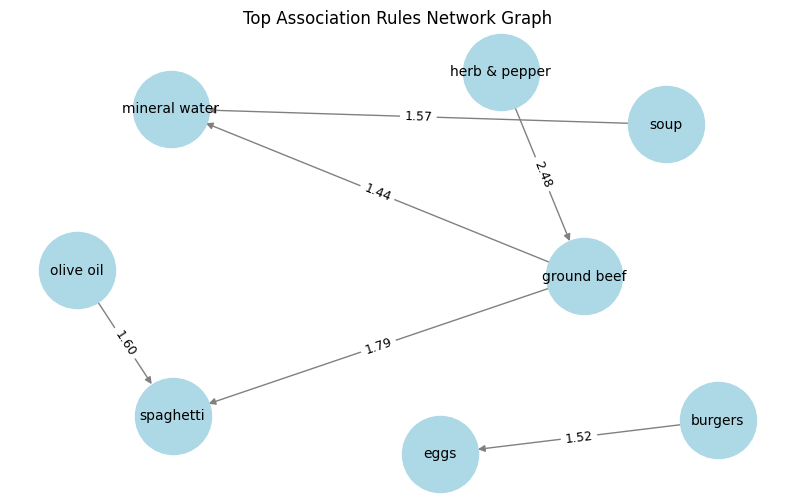

In [215]:
plot_network_graph(narrow_rules)

In [216]:
narrow_rules.sort_values(by='lift', ascending=False)[['antecedents','consequents','support','confidence','lift','jaccard','certainty','zhangs_metric']]

,antecedents,consequents,support,confidence,lift,jaccard,certainty,zhangs_metric
35,(herb & pepper),(ground beef),0.021642,0.331343,2.480963,0.122112,0.228276,0.638644
37,(ground beef),(spaghetti),0.054007,0.404380,1.794172,0.177110,0.231075,0.510869
74,(olive oil),(spaghetti),0.030610,0.360092,1.597673,0.109408,0.173901,0.408844
64,(soup),(mineral water),0.032560,0.466480,1.570964,0.097433,0.241148,0.390720
9,(burgers),(eggs),0.035290,0.314783,1.518833,0.124228,0.135642,0.384731
36,(ground beef),(mineral water),0.056931,0.426277,1.435572,0.152401,0.183965,0.350182


## <h2 style="color:purple">3. Analysis and Interpretation </h2>

**1. (Soup) → (Mineral Water)**

We have many grocery items where mineral water appears as a consequent, meaning it is commonly bought alongside various products. This doesn't necessarily indicate a strong association but rather suggests that mineral water is a staple item that is frequently purchased. 

**2. (Herb & Pepper) → (Ground Beef)**

This is an intuitive association because herbs and pepper are often used as seasonings for meat dishes.But, groud beef seems to the meat mostly associated with herbs and Pepper. It has the highest lift among the association.

**3. (Ground Beef) → (Spaghetti)**

This is a classic meal combination! Ground beef is a key ingredient in many pasta dishes, such as spaghetti Bolognese or lasagna.
The lift (1.79) suggests that spaghetti is nearly twice as likely to be purchased when ground beef is in the basket.
The confidence (40.4%) shows a moderately strong connection, meaning that 40% of the time when someone buys ground beef, they also get spaghetti.

**4. (Olive Oil) → (Spaghetti)**

Olive oil is commonly used in Italian cooking, making this association very logical. 

**5. (Burgers) → (Eggs)**

While eggs are a versatile ingredient, they are not directly linked to burger preparation. Unlike the other rules, this one is not an obvious culinary connection. Possible reasons can be:
- A customer buying burgers might also be picking up eggs for a big breakfast meal.
- Customer opting for protein rich diet

In conclusion we can say that customers buy ingredients with specific recipes in mind rather than just randomly adding items to their cart.It highlights meal-planning behaviors among customers. Stores could use this insight to create bundled deals, like “Spaghetti Night” packs with pasta, ground beef, and another other item they want the customers to try or purchase.

## <h2 style="color:purple">4. Q and A </h2>

**1.	What is lift and why is it important in Association rules?**

Lift is a metric used in association rule mining to measure how much more likely two items are to be purchased together compared to if they were independent. It helps in identifying strong relationships between items in a dataset.

#### Lift Formula  
$$
\text{Lift} = \frac{P(X \cap Y)}{P(X) \times P(Y)}
$$

Where:  
$$( P(X \cap Y) ) = Support of (X → Y) $$<br>
$$ ( P(X) ) = Support of antecedent (X)  $$<br>
$$( P(Y) ) = Support of consequent (Y) $$<br>



Importance:

Identifies Strong Associations: Lift helps determine whether items are truly related or if their co-occurrence is just due to chance.

Interprets the Strength of a Rule:
- Lift > 1: A and B are positively correlated (more likely to appear together).
- Lift = 1: A and B are independent (no association).
- Lift < 1: A and B are negatively correlated (less likely to appear together).

**2. What is support and Confidence. How do you calculate them?**

1. Support
Support measures how frequently an item or itemset appears in the dataset. It helps identify commonly bought items.

$$
\text{Support(A)} =\frac{\text{Number of transactions containing A}}{\text{Total number of transaction}}
$$


2. Confidence
Confidence measures how often item B is purchased when item A is purchased. It indicates the strength of a rule.

$$
\text{Confidence(A → B)} =\frac{\text{Support(A ∩ B)}}{\text{Support(A)}}
$$

Importance:

- Support ensures rules are based on frequent transactions.
- Confidence helps measure the reliability of an association.

**3. What are some limitations or challenges of Association rules mining?**

- **High Computational Cost** – Processing large datasets requires multiple scans, making it slow and resource-intensive. Algorithms like Apriori struggle with massive datasets.

- **Large Number of Rules** – Generates too many rules, including redundant or unimportant ones, making analysis difficult.

- **Difficulty in Setting Thresholds**  – Choosing appropriate support and confidence values is challenging, as too high or too low values may miss useful patterns.

- **Lack of Contextual Understanding** : Association rules only show correlations, not causation. Without domain knowledge, misleading rules may be generated (e.g., a rule could suggest buying "diapers and beer" without explaining why).



# <center><h3 style = "color:navy;">End of assignment</h3></center>